In [1]:
import numpy as np
import matplotlib.pyplot as plt

from problem import Problem, Action
from algorithms import Sarsa

In [2]:
for i in range(20):
    print(Sarsa.choose_action().name, end=', ')

A, B, B, B, A, A, B, A, B, B, B, B, B, B, B, B, B, B, B, B, 

In [3]:
p = Problem()
p.transition_probs.shape

(2, 7, 7)

In [4]:
p.transition_probs_a


array([[0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [5]:
p.transition_probs_b

array([[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.        ]])

In [6]:
for i in range(10):
    print(p.take_action(p.State.S1, Action.A).name, end=", ")

S7, S7, S7, S7, S7, S7, S7, S7, S7, S7, 

In [7]:
for i in range(10):
    print(p.take_action(p.State.S1, Action.B).name, end=", ")

S5, S6, S5, S6, S4, S5, S3, S5, S5, S6, 

In [8]:
p.transition_probs[0, 1]

array([0., 0., 0., 0., 0., 0., 1.])

In [9]:
np.random.choice(p.STATES, p=p.transition_probs[0, 1])

<State.S7: 6>

In [10]:
sarsa = Sarsa(p, 15)
sarsa.phi.shape

(7, 2, 15)

In [11]:
sarsa.phi[:, 0]

array([[2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0]])

In [12]:
sarsa.phi[:, 1]

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [16]:
w_init = np.array(6*[1] + [10] + 8 * [1]).astype(float)
w_init

array([ 1.,  1.,  1.,  1.,  1.,  1., 10.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.])

In [17]:
sarsa.phi @ w_init

array([[ 3.,  1.],
       [ 3.,  1.],
       [ 3.,  1.],
       [ 3.,  1.],
       [ 3.,  1.],
       [ 3.,  1.],
       [12.,  1.]])

In [18]:
sarsa_w_norms, sarsa_states, sarsa_actions = sarsa.run(w_init=w_init, n_steps=20)
for s, a in zip(sarsa_states, sarsa_actions):
    print(f"{s.name}, {a.name}, ", end='')
print(sarsa_states[-1].name)

S7, B, S1, B, S1, B, S2, A, S7, B, S1, B, S3, B, S6, B, S3, B, S2, B, S5, A, S7, B, S1, A, S7, B, S4, A, S7, B, S1, B, S3, B, S5, B, S5, B, S3


In [19]:
np.array(sarsa_w_norms)

array([10.67707825, 10.67706889, 10.67705952, 10.67892252, 10.67336875,
       10.67337766, 10.67334938, 10.67334002, 10.67333055, 10.67332128,
       10.67516601, 10.66970267, 10.67152921, 10.66620578, 10.66803025,
       10.66284276, 10.66281442, 10.66278622, 10.66277703, 10.66276766,
       10.6627581 ])

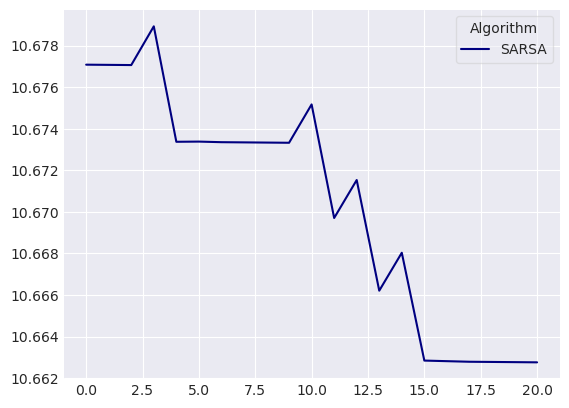

In [20]:
%matplotlib inline

with plt.style.context('seaborn-v0_8-darkgrid'):
    fig, ax = plt.subplots()
    ax.plot(np.arange(len(sarsa_w_norms)), np.array(sarsa_w_norms), label='SARSA', c='navy')

    ax.legend(frameon=True, fancybox=True, framealpha=0.5, title="Algorithm")